![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
###                  Welcome to The QuantConnect Research Page
Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter

Contribute to this template file https://github.com/QuantConnect/Lean/blob/master/Jupyter/BasicQuantBookTemplate.ipynb

<h1 align = "center"> Fundamental Factor Analysis Research </h1>

Many different fundamental-specific factors can influence the return on any individual stock. This research will show how to find significant factors to explain the stocks return and build the multi-factor model.

In [1]:
%matplotlib inline
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *

In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta
from calendar import monthrange
%pylab inline 
# Create an instance
qb = QuantBook()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Choose a basket of symbols as our universe sample 
- Here we choose 100 stocks from over 8000 quantconnect universe which have fundamental data. Those symbols are chosen at 2011-01-01.
- First, we sort the stocks by daily dollar volume and take the top stocks with the highest dollar volumes as our candidates. This step can be done by using QuantConnect backtest universe selection API.

In [3]:
symbols = [u'AAPL', u'C', u'XOM', u'JPM', u'GOOG', u'MSFT', u'LVS', u'INTC', u'AMZN', 
           u'CSCO', u'F', u'WFC', u'NFLX', u'FCX', u'QCOM', u'PBR', u'GS', u'JNJ', u'WMT',
           u'VALE', u'HPQ', u'GE', u'CVX', u'ORCL', u'IBM', u'POT', u'BIDU', u'MRK', u'PG', u'VZ',
           u'KO', u'PCLN', u'MS', u'BP', u'CMCSA', u'MCD', u'PFE', u'T', u'COP', u'CAT', 
           u'SLB', u'MA', u'BA', u'DTV', u'APC', u'V', u'MOS', u'PEP', u'EBAY', u'NEM', u'NTAP',
           u'AMGN', u'WYNN', u'CRM', u'CLX', u'S', u'ABX', u'OXY', u'ABT', u'TEVA', u'USB', u'FFIV', 
           u'GILD', u'MON', u'NVDA', u'SLW', u'HAL', u'AXP', u'MGM', u'TGT', u'MU', u'UPS', u'BTU',
           u'EXPE', u'CLF', u'CNX', u'ESRX', u'PM', u'MET', u'CMG', u'CF', u'UNH', u'BBY', u'CHK',
           u'COST', u'RIG', u'AIG', u'EMR', u'CME', u'CVS', u'DIS', u'CL', u'UNP', u'DE', u'DD',
           u'NOV', u'HD']
symbols.sort()

In [4]:
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime.now()
num_stocks = 45 # should be less than len(symbols)
num_ports = 5

### 2. Get Fundamental Data

- *GetFundamental([symbol], selector, start_date = datetime(1998,1,1), end_date = datetime.now())*

We will get a pandas.DataFrame indexed by the date.

In [6]:
data = qb.GetFundamental(symbols, "ValuationRatios.PERatio", start_date, end_date)

In [7]:
df = data
# fill the NaN with the forward data, 
# drop the NaN rows, 
# transpose the dataframe with the symbol index
df = df.fillna(method='ffill').dropna().T
df.index= symbols # change index to symbol names
# remove the stocks if there are zero values
df = df[~(df == 0).any(axis=1)][:num_stocks]
# change columns name to date type
df.columns =[i.date() for i in df.columns]

In [8]:
drop_columns = []
for i in range(len(df.columns)):
    date = df.columns[i]
    end_day_of_month = date.replace(day=monthrange(date.year, date.month)[1])
    if date != end_day_of_month:
        drop_columns.append(df.columns[i])
# drop columns if it is not the last day of the month        
df = df.drop(drop_columns, axis=1)

### 3. Get History Close Price
We can use the QuantConnect API to make Historical Data Requests. The data will be presented as multi-index pandas.DataFrame where the first index is the Symbol.

In [9]:
# create a dictionary keyed by symbols, valued by a list of history close
# add the benchmark "SPY"
hist = {}
sym_list = list(df.index)
sym_list.append(u'SPY')
for symbol in sym_list:    
    qb.AddEquity(symbol) 
    history = qb.History(symbol, start_date, end_date, Resolution.Daily).loc[symbol]["close"]
    hist[symbol] = history

### Compute the monthly return of portfolios
- We extract the factor values of candidate stocks at the beginning of each month and On each month, we sort the stocks in ascending order of their factor values, get a list of sorted symbols.
- At the end of each month, we extract the one-month history close prices of each stock and compute the monthly returns.
- Divide the stocks into 5 portfolios and compute the average monthly returns of each portfolio. Then we add the monthly return of benchmark "SPY" at the last line of the data frame of portfolio monthly return.


In [5]:
def port_monthly_return(syls, month_date):
    # syls(list): symbols
    # month_date(datetime.date): date for calculate the monthly return
    # return value: a list of average return for each portfolio
    num_each_port = int(num_stocks/float(num_ports))
    port_ret = []
    for i in range(num_ports):
        sum_ret = 0  # the sum of return in one portfolio
        for j in range(i*num_each_port,(i+1)*num_each_port):
            price = hist[syls[j]].to_frame()[month_date.strftime("%Y-%m")]
            sum_ret += (price.iloc[-1] - price.iloc[0]) / price.iloc[0]
        port_ret.append(np.mean(sum_ret)) 
    # add monthly return of "SPY" to the end of the list
    hist_benchmark = hist[syls[-1]].to_frame()[month_date.strftime("%Y-%m")]
    res_benchmark = (hist_benchmark.iloc[-1] - hist_benchmark.iloc[0]) / hist_benchmark.iloc[0]
    port_ret.append(res_benchmark[0])
    return port_ret

In [11]:
ret = []
for i in range(len(df.columns)):
    ranked_syls = df.sort_values(df.columns[i]).index  
    ret.append(port_monthly_return(ranked_syls,df.columns[i]))
df_return = pd.DataFrame(ret, index = df.columns)

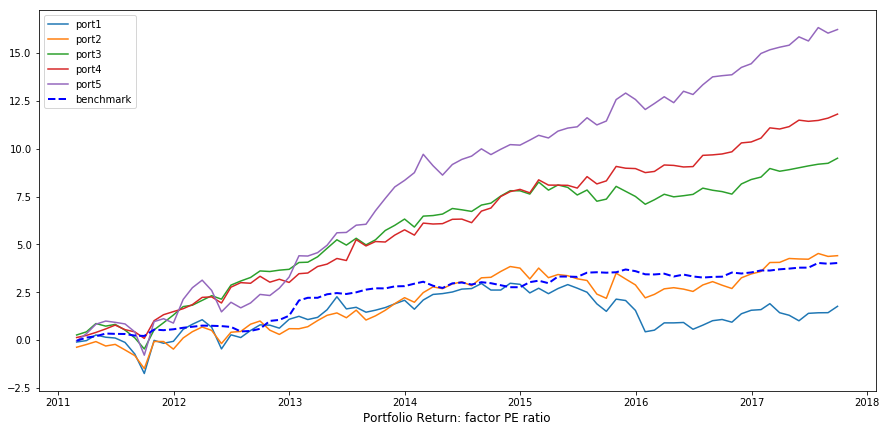

In [12]:
# plot the cumulative return for five portfolios and the benchmark
plt.figure(figsize =(15,7))
for i in range(num_ports):
    plt.plot(df_return.cumsum()[i], label = 'port%d'%(i+1))
plt.plot(df_return.cumsum()[num_ports], label = 'benchmark', linestyle='--', color='b', linewidth=2)
plt.xlabel('Portfolio Return: factor PE ratio', fontsize=12)
plt.legend(loc=0)

### Generate the metrics to test the factor significance
After getting the monthly returns of portfolios and the benchmark, we compute the average annual return and excess return over benchmark of each portfolio across the whole backtesting period. Then We generate metrics to judge the significance of each factor.

In [13]:
total_return = {}
annual_return = {}
excess_return = {}
win_prob = {}
loss_prob = {}
effect_test = {}
MinCorr = 0.3
Minbottom = -0.05
Mintop = 0.05
effect_test = {}
total_return = (df_return+1).cumprod().iloc[-1,:]-1
for i in range(len(total_return)):
    if total_return.iloc[i]<-1:
        total_return.iloc[i] = -0.99999
num_years = len(df_return)/12.0
annual_return = list((total_return+1)**(12.0/len(df_return))-1)
excess_return = list(annual_return - annual_return[-1])

### Metrics 1:
The correlation between the portfolio' returns and their rank. The higher the absolute value of the correlation coefficient, the more significant of the factor.

### Metrics 2:
If the return of the rank first portfolio larger than the portfolio at the bottom of the return rankings, we define it as the win portfolio and the loss portfolio and vice versa. The win probability is the probability that the win portfolio return outperform the benchmark return. The loss probability is the probability that the loss portfolio return underperform the benchmark.  the higher the win and loss probability, the more significant of the factor 

### Metrics 3:
The excess return of the win portfolio should be greater than 0.25, while the excess return of loss portfolio should be lower than 0.0

In [14]:
result =[]
correlation = np.corrcoef(annual_return[:num_ports],[i+1 for i in range(num_ports)])[0][1]
result.append(correlation)

In [15]:
if total_return.iloc[0]<total_return.iloc[-2]:
    loss_excess = df_return.iloc[:,0]-df_return.iloc[:,-1]
    loss_prob = loss_excess[loss_excess<0].count()/float(len(loss_excess))
    win_excess = df_return.iloc[:,-2]-df_return.iloc[:,-1]
    win_prob = win_excess[win_excess>0].count()/float(len(win_excess))
    result.append(loss_prob)
    result.append(win_prob)
    
    excess_return_win = excess_return[-2]
    excess_return_loss = excess_return[0]
    result.append(excess_return_win)
    result.append(excess_return_loss)    
    
elif total_return.iloc[0]>total_return.iloc[-2]:
    loss_excess = df_return.iloc[:,-2]-df_return.iloc[:,-1]
    loss_prob = loss_excess[loss_excess<0].count()/float(len(loss_excess))
    win_excess = df_return.iloc[:,0]-df_return.iloc[:,-1]
    win_prob = win_excess[win_excess>0].count()/float(len(win_excess))
    result.append(loss_prob)
    result.append(win_prob)
    
    excess_return_win = excess_return[0]
    excess_return_loss = excess_return[-2]
    result.append(excess_return_win)
    result.append(excess_return_loss)    

In [16]:
result

[0.96153705353134022,
 0.48749999999999999,
 0.67500000000000004,
 1.7813368263378662,
 -1.4452395122894701]

## Test the significance of multiple Factors
Next we test the significance for multiple factors to detect the effective factors. Here I choose 8 factors in Valueation Ratios. More factors like earning ratios, OperationRatios and other factors in financial statments can be found here https://www.quantconnect.com/data#fundamentals/usa/morningstar

In [8]:
factors = ["ValuationRatios.PERatio", "ValuationRatios.BookValuePerShare", 
           "ValuationRatios.FCFYield", "ValuationRatios.BookValueYield",
           "ValuationRatios.PricetoEBITDA","ValuationRatios.EVToEBITDA",
            "ValuationRatios.SalesPerShare", "ValuationRatios.EarningYield",
            "ValuationRatios.TrailingDividendYield","ValuationRatios.PriceChange1M",
            "ValuationRatios.TangibleBookValuePerShare","ValuationRatios.PEGRatio",
            "ValuationRatios.PCFRatio",  "ValuationRatios.PBRatio",
            "ValuationRatios.CFYield", "ValuationRatios.WorkingCapitalPerShare",
            "ValuationRatios.ExpectedDividendGrowthRate","ValuationRatios.SalesYield"]

In [ ]:
factor_test = {}
for factor_name in factors:
    
    data = qb.GetFundamental(symbols, factor_name, start_date, end_date)
    df = data
    # fill the NaN with the forward data, 
    # drop the NaN rows, 
    # transpose the dataframe with the symbol index
    df = df.fillna(method='ffill').dropna().T
    df.index= symbols # change index to symbol names
    # remove the stocks if there are zero values
    df = df[~(df == 0).any(axis=1)][:num_stocks]
    # change columns name to date type
    df.columns =[i.date() for i in df.columns]

    
    drop_columns = []
    for i in range(len(df.columns)):
        date = df.columns[i]
        end_day_of_month = date.replace(day=monthrange(date.year, date.month)[1])
        if date != end_day_of_month:
            drop_columns.append(df.columns[i])
    # drop columns if it is not the last day of the month        
    df = df.drop(drop_columns, axis=1)
    
    # create a dictionary keyed by symbols, valued by a list of history close
    # add the benchmark "SPY"
    hist = {}
    sym_list = list(df.index)
    sym_list.append(u'SPY')
    for symbol in sym_list:    
        qb.AddEquity(symbol) 
        history = qb.History(symbol, start_date, end_date, Resolution.Daily).loc[symbol]["close"]
        hist[symbol] = history
    

    ret = []
    for i in range(len(df.columns)):
        ranked_syls = df.sort_values(df.columns[i]).index  
        ret.append(port_monthly_return(ranked_syls,df.columns[i]))
    df_return = pd.DataFrame(ret, index = df.columns)
    
    
    # plot the cumulative return for five portfolios and the benchmark
    plt.figure(figsize =(13,6))
    for i in range(num_ports):
        plt.plot(df_return.cumsum()[i], label = 'port%d'%(i+1))
    plt.plot(df_return.cumsum()[num_ports], label = 'benchmark', linestyle='--', color='b', linewidth=2)
    plt.xlabel('Portfolio Return: factor %s'%factor_name, fontsize=12)
    plt.legend(loc=0)
 

    total_return = (df_return+1).cumprod().iloc[-1,:]-1
    for i in range(len(total_return)):
        if total_return.iloc[i]<-1:
            total_return.iloc[i] = -0.99999
    num_years = len(df_return)/12.0
    annual_return = list((total_return+1)**(12.0/len(df_return))-1)
    excess_return = list(annual_return - annual_return[-1])
    
    
    result =[]
    correlation = np.corrcoef(annual_return[:num_ports],[i+1 for i in range(num_ports)])[0][1]
    result.append(correlation)
    
    if total_return.iloc[0]<total_return.iloc[-2]:
        loss_excess = df_return.iloc[:,0]-df_return.iloc[:,-1]
        loss_prob = loss_excess[loss_excess<0].count()/float(len(loss_excess))
        win_excess = df_return.iloc[:,-2]-df_return.iloc[:,-1]
        win_prob = win_excess[win_excess>0].count()/float(len(win_excess))
        result.append(loss_prob)
        result.append(win_prob)

        excess_return_win = excess_return[-2]
        excess_return_loss = excess_return[0]
        result.append(excess_return_win)
        result.append(excess_return_loss)    
    
    elif total_return.iloc[0]>total_return.iloc[-2]:
        loss_excess = df_return.iloc[:,-2]-df_return.iloc[:,-1]
        loss_prob = loss_excess[loss_excess<0].count()/float(len(loss_excess))
        win_excess = df_return.iloc[:,0]-df_return.iloc[:,-1]
        win_prob = win_excess[win_excess>0].count()/float(len(win_excess))
        result.append(loss_prob)
        result.append(win_prob)

        excess_return_win = excess_return[0]
        excess_return_loss = excess_return[-2]
        result.append(excess_return_win)
        result.append(excess_return_loss) 
    
    factor_test[factor_name] = result

In [19]:
pd.DataFrame(factor_test, 
             index = ['correlation','loss probability','win probability',
                      'excess return(win)','excess return(loss)'])

,ValuationRatios.BookValuePerShare,ValuationRatios.BookValueYield,ValuationRatios.CashReturn,ValuationRatios.EVToEBITDA,ValuationRatios.EarningYield,ValuationRatios.FCFYield,ValuationRatios.PERatio,ValuationRatios.PricetoEBITDA
correlation,-0.496643,-0.910746,-0.136929,0.819191,-0.247366,0.076611,0.961537,0.760482
loss probability,0.437500,0.537500,0.425000,0.437500,0.450000,0.462500,0.487500,0.487500
win probability,0.587500,0.687500,0.562500,0.700000,0.550000,0.525000,0.675000,0.662500
excess return(win),0.410495,1.821580,-0.658219,1.415108,-0.677539,-0.678577,1.781337,1.016998
excess return(loss),-0.435370,-0.717739,-0.737427,-0.502127,-0.736370,-0.763143,-1.445240,-0.991618


#### Conclusion
- From the above plot and the factor test result statistics, among all these factors, BookValueYield and PE Ratio the most significant one that can explain the return. But BookValueYield is negatively correlated with stock return but PE Ratio is positively correlated with return. 
- For example BookValueYield, the correlation is negative, but the absolute value is high. Both the loss prability and the win probability are over 0.5. The excess return for win portfolio is positive and the excess return for loss portfolio is negative. 
- In the following research, we ca ntest more factors and pick the significant ones as independent variables in multi-factor models. Or in long/short strategies, rank the stocks according to those significant factors to generate the positive returns.